In [1]:
import warnings
warnings.simplefilter("ignore")

In [2]:
import sys
sys.path.append('..')

In [3]:
import numpy as np

import keras
import keras.backend as K

Using Theano backend.
Using cuDNN version 5110 on context None
Mapped name None to device cuda1: TITAN X (Pascal) (0000:02:00.0)


In [4]:
K.theano.config.optimizer = 'fast_compile'

We'll demonstrate on VGG16 pre-trained on imagenet

In [5]:
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions

# put a single or batch image into the correct format for
# classification on the pre-trained model
def pp(x):
    if np.ndim(x) == 3:
        x = np.expand_dims(x, 0)
    if x.shape[1] != 3:
        x = x.transpose((0,3,1,2))
    return preprocess_input(np.array(x, copy=True), mode='th')

model = VGG16(include_top=True, weights='imagenet')

In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3, 224, 224)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 224, 224)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 224, 224)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 112, 112)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 112, 112)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 112, 112)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 128, 56, 56)       0         
__________

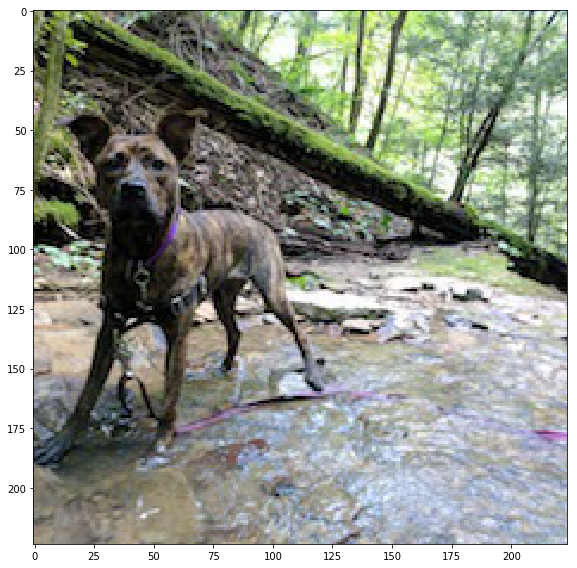

In [7]:
from skimage import io, transform
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 8)

def fetch_image(url):
    im = transform.resize(io.imread(url), (224,224,3))
    im *= 255.
    return im.astype(np.uint8)

x = fetch_image('images/img1.jpeg')
io.imshow(x)

In [8]:
decode_predictions(model.predict(pp(x)))

[[(u'n02116738', u'African_hunting_dog', 0.26429653),
  (u'n02113978', u'Mexican_hairless', 0.1345735),
  (u'n02099849', u'Chesapeake_Bay_retriever', 0.08482832),
  (u'n02117135', u'hyena', 0.06600039),
  (u'n02115641', u'dingo', 0.060701013)]]

Like many who meet her, this VGG16 thinks Astrid looks like a hyena.

# Computing attributions

We generally want to compute attributions over the logit predictions.

Because the pre-trained VGG16 does not have a dedicated softmax layer, we need to decompose the final layer graph to get the probit tensor before the softmax operations.

In [9]:
softmax = model.layers[-1].output.get_parents()[0]
logits = softmax.inputs[0]

Attributions are taken with respect to a quantity of interest. 
By default this quantity is just the model's full output, aggregated by summation.

Intuitively, the quantity describes what aspect of the model's behavior the attributions account for.
We will set the quantity to be the logit value of the most likely class.

If $F(x)$ is the logits at $x$, then we want the dot product between the logit vector and the one-hot encoding of its argmax:

$$
Q = F(x) \cdot \mathsf{onehot}(\mathsf{argmax}(F(x))
$$

In [10]:
n_classes = model.output_shape[1]
Q = K.batch_dot(logits, K.one_hot(K.argmax(logits, axis=1), n_classes), axes=1)

Let's confirm that we have the right tensor for Q

In [11]:
logit_fn = K.function([model.input], [logits])
Q_fn = K.function([model.input], Q)
logit_fn([pp(x)])[0].max(), Q_fn([pp(x)])[0][0]

(12.444426, 12.444426)

Now let's compute some attributions using internal influence at ``block5_pool`` (layer 18).

In [12]:
%%time
from attribution import methods

infl = methods.AumannShapley(model, 18, Q=Q).compile()
infls = infl.get_attributions(pp(x))

CPU times: user 6.88 s, sys: 1.76 s, total: 8.63 s
Wall time: 8.64 s


It took a while to run the previous cell. 
Most of the time was consumed by ``compile()``, which is a one-time operation.
Subsequent calls to ``get_attributions`` will run much faster.

In [13]:
%%time
infls = infl.get_attributions(pp(x))

CPU times: user 4.3 s, sys: 1.86 s, total: 6.15 s
Wall time: 6.15 s


By default, ``get_attributions`` returns a numpy array of shape ``(batch size, layer size)``.

In [14]:
infls.shape

(1, 512)

Notice that the second dimension only has 512 elements, whereas ``block5_pool`` outputs shape ``(512, 7, 7)``.

This is due to another default setting for ``AumannShapley``, which treats each filter in a convolutional layer as a distinct unit of attribution.
This is controlled by the ``agg_fn`` argument to the constructor. Its default value is ``K.max``, which means that each feature map is aggregated by taking its maximum value. 
``agg_fn`` can be set to any Keras backend function that takes a tensor as its only positional argument, and uses an ``axis`` keyword argument (e.g., ``K.sum``, ``K.prod``, etc).

It can also be set to ``None``, which causes the attributer to flatten the convolutional layer.
Note that this will take significantly longer to compile, as there are many more elements in the feature maps!

Let's see this on ``block5_pool`` (layer 18), which has smaller feature maps so should be faster than if we tried on ``block3_pool``.

In [15]:
%%time
infl_18 = methods.AumannShapley(model, 18, Q=Q, agg_fn=None).compile()
infls_18 = infl_18.get_attributions(pp(x))

CPU times: user 660 ms, sys: 76 ms, total: 736 ms
Wall time: 731 ms


In [16]:
infls_18.shape

(1, 25088)

When using ``agg_fn=None``, it may also make sense to specify ``match_layer_shape=True`` when calling ``get_attributions``.
This causes ``get_attributions`` to return an array of the same shape as the targeted layer, which can simplify constructing visualizations and heatmaps from the attributions.

In [17]:
infls_18 = infl_18.get_attributions(pp(x), match_layer_shape=True)
infls_18.shape

(1, 512, 7, 7)

### Other attribution methods

At the moment, two additional attribution methods are implemented:
* Conductance (from https://arxiv.org/pdf/1805.12233.pdf).
* Activation (i.e., the attribution of a unit is simply its activation).

Their interfaces are identical to ``AumannShapley``, except for method-specific arguments to the constructor.
For example, it does not make sense to use a quantity of interest when computing activations.

In [18]:
%%time
cond = methods.Conductance(model, 18, Q=Q, agg_fn=K.max).compile()
conds = cond.get_attributions(pp(x))

CPU times: user 19.2 s, sys: 9.66 s, total: 28.9 s
Wall time: 30 s


Notice that conductance takes a really long time to run.
Most of the time, there is not a good reason to use this method, as very similar results will follow from the (much faster) internal influence.
Of course, activation is the fastest attribution method as seen below, but delivers very different results.

In [19]:
%%time
act = methods.Activation(model, 18).compile()
acts = act.get_attributions(pp(x))

CPU times: user 2.57 s, sys: 324 ms, total: 2.9 s
Wall time: 2.83 s


Both methods return arrays formatted in the same way as ``AumannShapley``

In [20]:
print(conds.shape, acts.shape)

((1, 512), (1, 512))


Comparing each method on this image by looking at the top-10 units by attribution, we see that internal influence and conductance agree on the most important neurons.
Activation agrees with the others only on the top unit.

In [21]:
infls_top10 = infls[0].argsort()[::-1][:10]
conds_top10 = conds[0].argsort()[::-1][:10]
acts_top10 = acts[0].argsort()[::-1][:10]
print(infls_top10)
print(conds_top10)
print(acts_top10)

[ 69  80 409 349  70 274 198 203  79 141]
[441  28 273 317 128  36 365 316 179 474]
[ 69 141 313 200 409 248  80 442 274 478]


# Visualizing results

Now that we've identified some important neurons, we can visualize them in various ways.
The most straightforward is to identify the influence of input pixels on the identified neurons. 

We create a quantity of interest that corresponds to the parts of the network identified as the top-10 most relevant by internal influence at layer ``block5_pool``.

In [22]:
%%time
Q_ii = sum(K.sum(model.layers[18].output[:,unit], axis=(1,2)) for unit in infls_top10)
input_ii = methods.AumannShapley(model, 0, Q=Q_ii, agg_fn=None).compile()

CPU times: user 1.3 s, sys: 44 ms, total: 1.35 s
Wall time: 1.71 s


In [23]:
%%time
input_infls = input_ii.get_attributions(pp(x), match_layer_shape=True)

CPU times: user 564 ms, sys: 176 ms, total: 740 ms
Wall time: 537 ms


The conductance and integrated gradients papers suggest visualizing attributes in the following way:
* Aggregate pixel-wise input attributions along the color channel
* Take the absolute value, so that negative and positive attributions are visualized alike
* Scale pixel intensities of the original image by the result

In [24]:
mean_infl = input_infls[0].mean(axis=0)
mean_infl = np.abs(mean_infl)
mean_infl = np.clip(mean_infl/np.percentile(mean_infl, 99), 0., 1.)
mean_infl.min(), mean_infl.max()

(0.0, 1.0)

Frankly, this approach leaves a lot to be desired.
Especially when attributions are taken at a lower layer, this doesn't tend to do much other than highlighting lighter parts of the image.
Because we worked on a higher layer, the visualization below gives an ok idea of where the important pixels are.

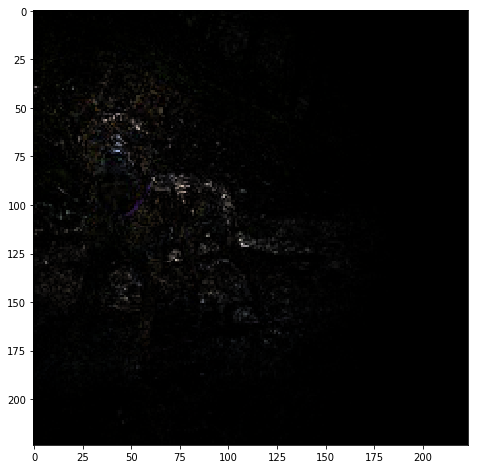

In [25]:
exp_infl = np.expand_dims(mean_infl, 2)
plt.gcf().set_size_inches(8,8)
plt.imshow(((exp_infl*x)).astype(np.uint8))

Visualizing the results as a raw heatmap is actually more useful, because pixels that are close to 0 will show up if they are influential.

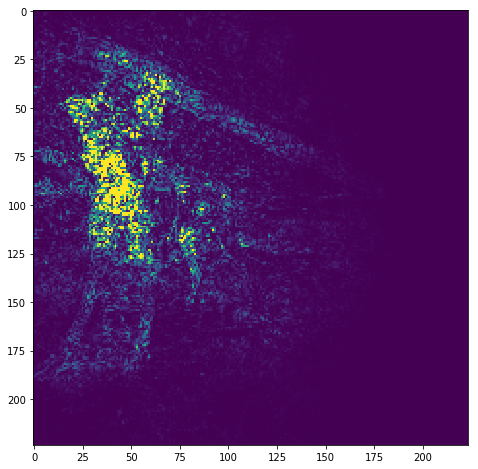

In [26]:
plt.gcf().set_size_inches(8,8)
plt.imshow(mean_infl)

A better approach is to threshold the most influential pixels by percentile, and blur the attributions to create a more continuous mask.

This is the approach taken by the ``TopKWithBlur`` visualizer, included in the library.
``VisualizationMethod`` subclasses all take an ``AttributionMethod`` argument to their constructor.
The ``TopKWithBlur`` also takes:
* ``k``: The top-k attribution units (neurons) identified by the given attributer will be visualized (default ``1``).
* ``alpha``: When the visualization mask is constructed, pixels outside of it will be multiplied by ``alpha`` (default ``0.01``).
* ``percentile``: The mask will be constructed by selecting the pixels above this percentile threshold (default ``95``).
* ``sigma``: Controls the size of the Gaussian blur applied to the mask.

Let's run this using our internal influence attributer from earlier, ``infl``.

In [27]:
from attribution import visualizations

vis = visualizations.TopKWithBlur(infl, k=10)

Unfortunately, the result looks awful because the model uses a preprocessing function that transforms colors.

CPU times: user 5.86 s, sys: 2 s, total: 7.86 s
Wall time: 7.64 s


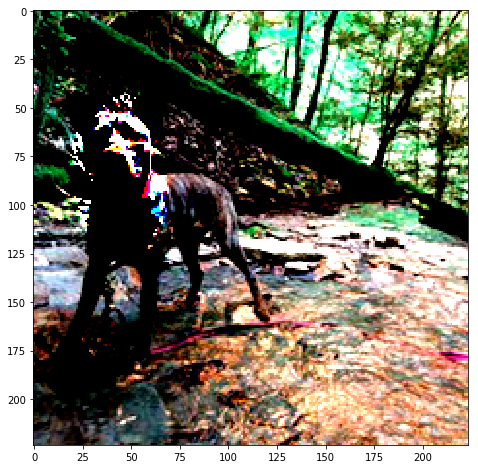

In [28]:
%%time
visr = vis.visualize(pp(x))
plt.gcf().set_size_inches(8,8)
plt.imshow(visr[0].transpose((1,2,0)))

We can also obtain the mask directly by calling ``vis.mask``, and visualize the result accordingly.
As seen below, this gives a more coherent visual explanation.

CPU times: user 6.4 s, sys: 2.08 s, total: 8.48 s
Wall time: 8.26 s


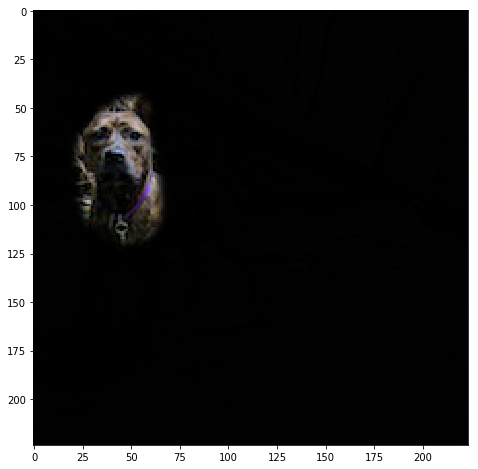

In [29]:
%%time
mask = vis.mask(pp(x))
plt.gcf().set_size_inches(8,8)
plt.imshow((x*mask.transpose((1,2,0))).astype(np.uint8))

We can just as easily visualize the attributions returned by conductance and activations.

CPU times: user 18.9 s, sys: 9.69 s, total: 28.6 s
Wall time: 28.5 s


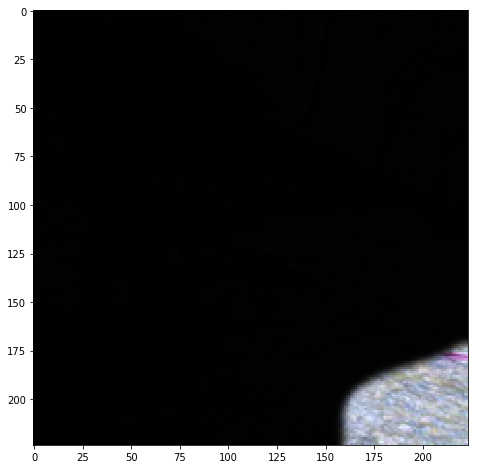

In [30]:
%%time
vis_cond = visualizations.TopKWithBlur(cond, k=10)
mask = vis_cond.mask(pp(x))
plt.gcf().set_size_inches(8,8)
plt.imshow((x*mask.transpose((1,2,0))).astype(np.uint8))

Conductance totally failed on this example. It seems to pick up the dog on other instances though.

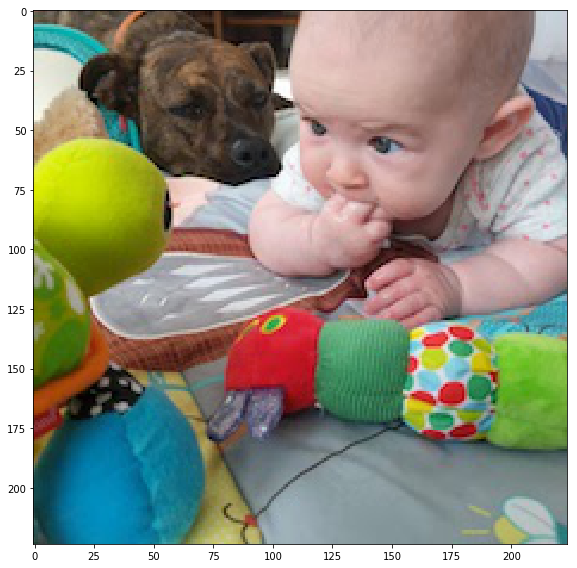

In [31]:
z = fetch_image('images/img2.jpeg')
plt.gcf().set_size_inches(8,8)
io.imshow(z)

In [32]:
decode_predictions(model.predict(pp(z)))

[[(u'n02090379', u'redbone', 0.24213007),
  (u'n04409515', u'tennis_ball', 0.077928215),
  (u'n02099849', u'Chesapeake_Bay_retriever', 0.06102096),
  (u'n03720891', u'maraca', 0.043201726),
  (u'n02093428', u'American_Staffordshire_terrier', 0.037195716)]]

CPU times: user 19.2 s, sys: 9.62 s, total: 28.8 s
Wall time: 28.8 s


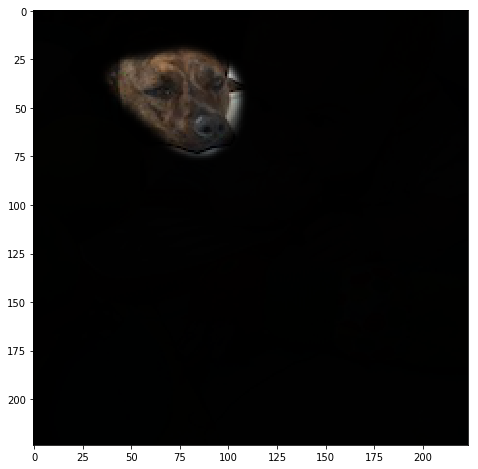

In [33]:
%%time
mask = vis_cond.mask(pp(z))
plt.gcf().set_size_inches(8,8)
plt.imshow((z*mask.transpose((1,2,0))).astype(np.uint8))

Finally, the activations visualization is close to the one given by internal influence.

CPU times: user 2.49 s, sys: 400 ms, total: 2.89 s
Wall time: 2.67 s


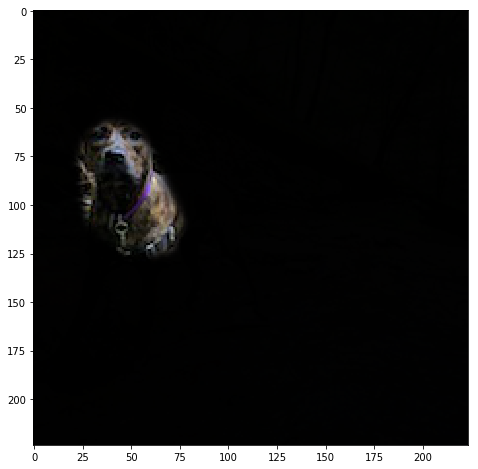

In [34]:
%%time
vis_act = visualizations.TopKWithBlur(act, k=5)
mask = vis_act.mask(pp(x))
plt.gcf().set_size_inches(8,8)
plt.imshow((x*mask.transpose((1,2,0))).astype(np.uint8))

# Attributing misclassification

Now suppose that we want to explain a different aspect of the model's output.
The second most likely class predicted for the ``z`` image above was 'tennis ball'.
There isn't a tennis ball in the picture, and it seems likely that the turtle head was mistakenly seen as this label.

We can confirm the hypothesis by formulating a quantity of interest that corresponds to the logit for tennis ball, and constructing an attributer+visualizer.

In [35]:
%%time
idx_tb = model.predict(pp(z))[0].argsort()[::-1][1]
Q_tb = logits[:,idx_tb]
infl_tb = methods.AumannShapley(model, 18, Q=Q_tb).compile()
vis_tb = visualizations.TopKWithBlur(infl_tb, k=1)

CPU times: user 1.95 s, sys: 32 ms, total: 1.98 s
Wall time: 1.96 s


CPU times: user 6.33 s, sys: 2.08 s, total: 8.4 s
Wall time: 8.18 s


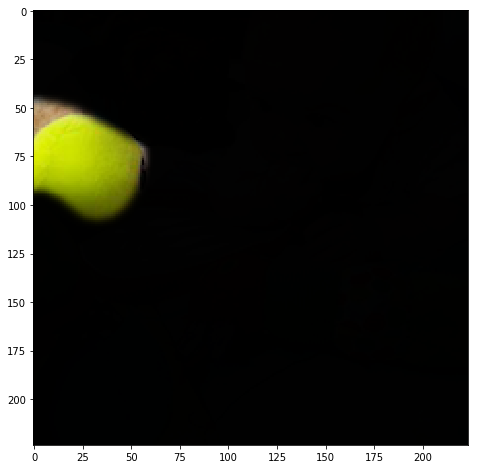

In [36]:
%%time
mask_tb = vis_tb.mask(pp(z))
plt.gcf().set_size_inches(8,8)
plt.imshow((z*mask_tb.transpose((1,2,0))).astype(np.uint8))

Indeed, the turtle was mistakenly labeled a tennis ball.
The 'maraca' label is also intriguing, let's see what it corresponds to.

In [37]:
%%time
idx_ma = model.predict(pp(z))[0].argsort()[::-1][3]
Q_ma = logits[:,idx_ma]
infl_ma = methods.AumannShapley(model, 18, Q=Q_ma).compile()
vis_ma = visualizations.TopKWithBlur(infl_ma, k=1)

CPU times: user 1.9 s, sys: 76 ms, total: 1.98 s
Wall time: 1.96 s


CPU times: user 6.51 s, sys: 1.97 s, total: 8.48 s
Wall time: 8.26 s


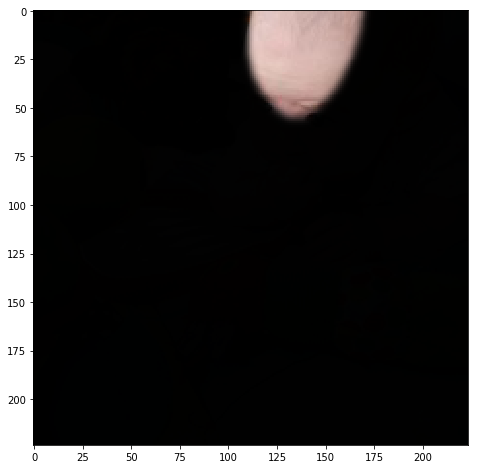

In [38]:
%%time
mask_ma = vis_ma.mask(pp(z))
plt.gcf().set_size_inches(8,8)
plt.imshow((z*mask_ma.transpose((1,2,0))).astype(np.uint8))

Baby's head is influential on the unit most responsible for maraca.
Why would this be the case?
Imagenet doesn't have a 'baby' class, but it does have 'diaper', which is often predicted with confidence when a baby is present in the image (regardless of whether a diaper is present).
We can construct a Q for the diaper class, and see what it picks up on.

In [39]:
%%time
idx_di = 529
Q_di = logits[:,idx_di]
infl_di = methods.AumannShapley(model, 18, Q=Q_di).compile()
vis_di = visualizations.TopKWithBlur(infl_di, k=1)

CPU times: user 1.89 s, sys: 76 ms, total: 1.97 s
Wall time: 1.94 s


CPU times: user 5.78 s, sys: 2.02 s, total: 7.8 s
Wall time: 7.57 s


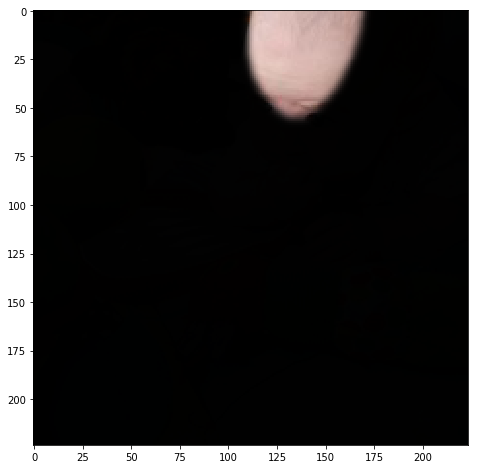

In [40]:
%%time
mask_di = vis_di.mask(pp(z))
plt.gcf().set_size_inches(8,8)
plt.imshow((z*mask_di.transpose((1,2,0))).astype(np.uint8))

The same visual result. It could be a fluke, or it could be that the same internal neuron is responsible for both predictions.

In [41]:
print(infl_di.get_attributions(pp(z))[0].argsort()[::-1][:5])
print(infl_ma.get_attributions(pp(z))[0].argsort()[::-1][:5])

[433 155 472 301 388]
[433 447 155 245 351]


The most influential unit at ``block5_pool`` towards both 'diaper' and 'maraca' is 433, which suggests that it must correspond to some visual feature that picks up on instances of either class.

We can use the keras-vis package to compute an image that maximizes the activation of this unit.
We see below that the unit activates on patterns that look like critters with bulbous heads.
Given this, it isn't surprising that the filter activates on the baby's head, but it isn't clear why this would be influential toward 'maraca'.

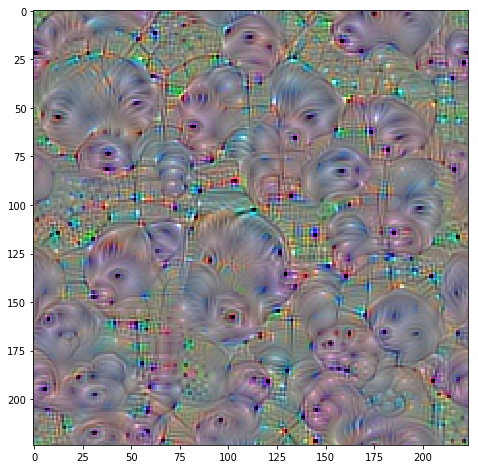

In [42]:
from vis.visualization import visualize_activation
from vis.input_modifiers import Jitter

img = visualize_activation(model, 18, filter_indices=433, tv_weight=0.,
                           input_modifiers=[Jitter(1)],
                           max_iter=500)
plt.gcf().set_size_inches(8,8)
plt.imshow(img)